# MEI Datajoint-Free Demo

Demo notebook to create MEIs from pretrained example model. Does not require connection to datajoint. 


In [1]:
# only need to run once at the beginning
import sys
sys.path.append('../')
!pip3 install -q git+https://github.com/sinzlab/nnvision.git@model_builder

In [2]:
import os
import torch
from mei.methods import gradient_ascent
from mei.modules import ConstrainedOutputModel
import urllib

import datajoint as dj
# some hackity hack to supress datajoint promts (ignore)
dj.config["database.host"] = "{host_address}"
dj.config["database.user"] = "{user}"
dj.config["database.password"] = "{password}"

import matplotlib.pyplot as plt
from nnfabrik.builder import get_model


### Download monkey V4 example model files

Download pretrained model for monkey V4 from https://github.com/sinzlab/nnvision and define function to load the model

In [3]:
# method for loading example model
def get_v4_model():

    # download example model
    os.makedirs('./pretrained_models', exist_ok=True)
    url = 'https://github.com/sinzlab/nnvision/raw/model_builder/nnvision/data/model_weights/v4_task_driven/task_driven_ensemble_model_01.pth.tar'
    filepath = './pretrained_models/task_driven_ensemble_model_01.pth.tar'
    if not os.path.exists(filepath):
        urllib.request.urlretrieve(url, filepath)

    model_fn = 'nnvision.models.ptrmodels.task_core_gauss_readout'
    model_config =  {'input_channels': 1,
    'model_name': 'resnet50_l2_eps0_1',
    'layer_name': 'layer3.0',
    'pretrained': False,
    'bias': False,
    'final_batchnorm': True,
    'final_nonlinearity': True,
    'momentum': 0.1,
    'fine_tune': False,
    'init_mu_range': 0.4,
    'init_sigma_range': 0.6,
    'readout_bias': True,
    'gamma_readout': 3.0,
    'gauss_type': 'isotropic',
    'elu_offset': -1,
                    }

    data_info = {
        "all_sessions": {
            "input_dimensions": torch.Size([64, 1, 100, 100]),
            "input_channels": 1,
            "output_dimension": 1244,
            "img_mean": 124.54466,
            "img_std": 70.28,
        },
    }

    filename = os.path.join('./pretrained_models/task_driven_ensemble_model_01.pth.tar')
    state_dict = torch.load(filename, map_location='cpu')

    v4_data_task_sota = get_model(
        model_fn, model_config, seed=10, data_info=data_info, state_dict=state_dict,
    )

    return v4_data_task_sota, data_info

### Load the model


In [4]:
model, data_info = get_v4_model()

c:\Users\Leon\miniconda3\envs\mei\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Leon\miniconda3\envs\mei\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\Leon\miniconda3\envs\mei\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[2024-03-08 10:58:03,167][INFO]: Connecting {user}@{host_address}:3306


datajoint connection not established, skipping model imports from nnfabrik tables


c:\Users\Leon\miniconda3\envs\mei\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Leon\miniconda3\envs\mei\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Create single cell model
Here you select the index of the cell for which you'd like to optimize the MEI

In [5]:
cell_index = 403
single_cell_model = ConstrainedOutputModel(model, cell_index)

### Configurations
Configurations for the MEI optimization algorithm

In [6]:
seed = 8

# learning rate
lr = 1

# number of iterations for which the MEI is optimized
num_iterations = 1000 

# interval with which the objective will be evaluated
interval = 10

# shape of the MEI
input_shape = (1,) + data_info["all_sessions"]['input_dimensions'][1:] 

device='cpu'

In [7]:
method_config = dict(
    initial=dict(path="mei.initial.RandomNormal"),
    optimizer=dict(path="torch.optim.SGD", kwargs=dict(lr=lr)),
    stopper=dict(path="mei.stoppers.NumIterations", kwargs=dict(num_iterations=num_iterations)),
    objectives=[dict(path="mei.objectives.EvaluationObjective", kwargs=dict(interval=interval))],
    device=device,
)

### Optimize MEI

In [8]:
mei, final_evaluation, tracker_log = gradient_ascent(model=single_cell_model, config=method_config, seed=seed, shape=input_shape)   

### Visualize MEI

torch.Size([1, 1, 100, 100])
tensor(38.2673)


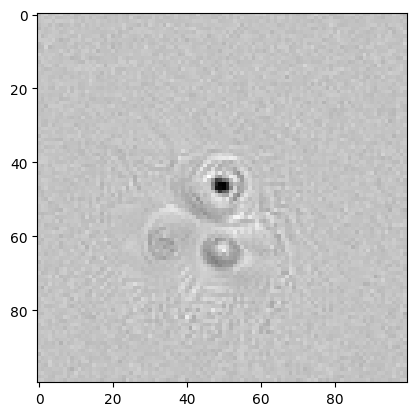

In [10]:
print(mei.shape)
print(torch.max(torch.abs(mei)))
plt.imshow(mei[0,0], cmap='gray')

Text(0, 0.5, 'evaluation')

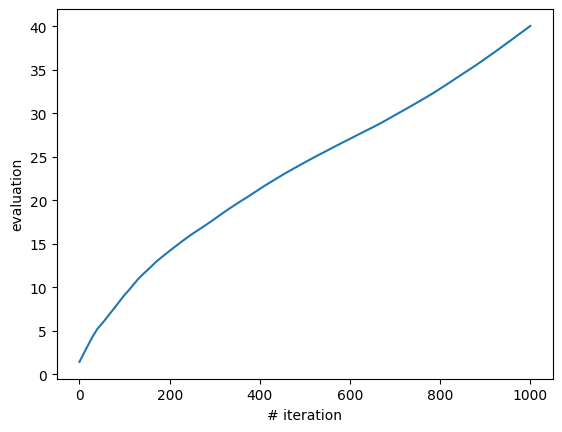

In [11]:
plt.plot(
    tracker_log["mei.objectives.EvaluationObjective"]["times"],
    tracker_log["mei.objectives.EvaluationObjective"]["values"],
)
plt.gca().set_xlabel("# iteration")
plt.gca().set_ylabel("evaluation")

### Constraints 
So far, we have not introduced contraints into MEI optimization. 
This results in implausible MEIs with high pixel values and high contrast and a forever increasing activation. We need to constrain the overall norm of the MEI and also clip the range of pixel values to the range of pixel values which were in the training data. 
The norm is then established empirically such, that ideally, value clipping is not necessary.

In [12]:
p = 2
norm_value = 10
max_pixel_value = 2.2606
min_pixel_value = -1.75047

method_config['postprocessing'] = dict(path="mei.postprocessing.PNormConstraintAndClip", 
                                       kwargs=dict(p=p, norm_value=norm_value, max_pixel_value=max_pixel_value, min_pixel_value=min_pixel_value))

In [13]:
mei, final_evaluation, tracker_log = gradient_ascent(model=single_cell_model, config=method_config, seed=seed, shape=input_shape)   

torch.Size([1, 1, 100, 100])
tensor(2.0273)


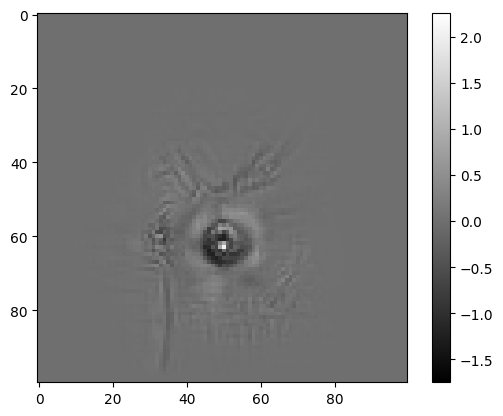

In [14]:
print(mei.shape)
max_value = torch.max(torch.abs(mei))
print(max_value)
plt.imshow(mei[0,0], cmap='gray', vmin=min_pixel_value, vmax=max_pixel_value)
plt.colorbar()
plt.show()


Text(0, 0.5, 'evaluation')

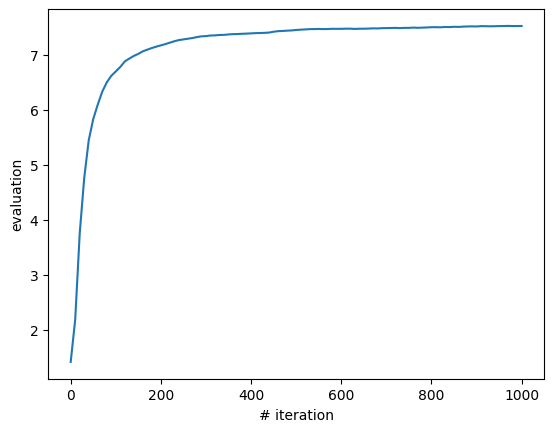

In [15]:
plt.plot(
    tracker_log["mei.objectives.EvaluationObjective"]["times"],
    tracker_log["mei.objectives.EvaluationObjective"]["values"],
)
plt.gca().set_xlabel("# iteration")
plt.gca().set_ylabel("evaluation")